In [1]:
# Biblioteca para trabalhar com dataframes e manipulacao de dados
import pandas as pd
import matplotlib.pyplot as plt

# Biblioteca para utilizar a api do twitter
import tweepy

# Biblioteca de Linguagem Natural
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier

# manipulacao de arquivo
import os
import pickle


# dados de conexao com twitter
CONSUMER_API_KEY = "PMrkmRMQy3n7yZnBcYM6"
CONSUMER_API_SECRET = "f3e9oFfDfw3MA8ZmrVUDO8UTdb3TFrOsdkGmWRmmzCx"
ACCESS_TOKEN = "92998645-EphmhVfonqO2YbXtBmRIcgZSpA6aoGt6nNPD8JAI9"
ACCESS_TOKEN_SECRET = "0MbzoFCMq4LrGcya8ro2XMrjBifteujAa3NnVsgepHDG4"


'''
Função que retorna um dataframe com os tweets buscados na API do Twitter
'''
def buscarTweets(api,local,numMaxTweets):
  tweets_buscados = []
  for tweet in tweepy.Cursor(api.search, q=local, tweet_mode='extended').items(numMaxTweets):
    texto = tweet.full_text
    tweets_buscados.append({'title': title, 'sentimento': '', 'avaliacao': '','text':texto, 'tweet': tweet._json})

  return pd.DataFrame(tweets_buscados)


'''
Função para receber um dataframe e um modelo de  NaiveBayes treinado
e realizar a a classificacao automatica da coluna sentimento retornando o proprio dataframe
'''
def classificandoDataframe (df, modelo):

  for i, row in df.iterrows(): #iterrows (entrelinhas) retorna uma série para cada linha
      sentenca = row.text.lower()
      sentimento = modelo.classify(formatar_sentenca(sentenca))
      df._set_value(i,'sentimento',sentimento)
      
  return df 

'''
Função que recebe um dataframe com os tweets buscados e classificados automaticamente para
que um humano possa avaliar o desempenho e retorna o dataframe atual mais as linhas do dataframe base para gerar um modelo maior
'''
def avaliandoAlgoritimo(df,dfBase):

  # avaliando os resultados classificados automaticamente
  for i, row in df.iterrows():
      #não vou avaliar o que eu ja classifiquei no primeiro treinamento
      if (dfBase['text'].eq(row.text)).any() :
        df._set_value(i,'avaliacao','x')
        continue

      print ('Tweet ' + str(i) + ':' + row.text)
      print ('Sentimento ' + ':' + row.sentimento)
      avaliacao = ''
      avaliacao = input('O algoritimo classificou corretamente N ou S ?')
      df._set_value(i,'avaliacao',avaliacao.lower())
  
  #garantir que entre uma rodada e outra um tweet que eu avaliei
  #na primeira rodada fique de fora desse novo df que vai servir 
  #para gerar outro modelo
  for i, row in dfBase.iterrows():
    if (df['text'].eq(row.text)).any() :
      continue

    #se nao encontrou adiciona
    df.append(row)

  return df

'''
Função que recebe os paramêtros de conexão, consulta, numero de tweets para buscar modelo treinamento e o dataframe anterior.
Ela executa 3 passos:
- Buscar tweets
- classificar automaticamente
- avaliar a classificação

retorno é um dataframe com os tweets buscados/classificados/avaliados + os do treinamento anterior
'''
def fluxoDeBusca(api,consulta,numMaxTweets,modelo,df_anterior):
  # primeira busca / classificacao e avaliacao
  df_novos = buscarTweets(api,consulta,numMaxTweets)

  # classificacao automatica sem repeticao
  df_novos = classificandoDataframe(df_novos,modelo)

  #avaliando algoritimo
  df_novos = avaliandoAlgoritimo(df_novos, df_anterior)

  return df_novos

def formatar_sentenca(sentenca):
   return {palavra: True for palavra in word_tokenize(sentenca)}

'''
Recebe um data frame e cria um array no formato que o algoritmo de nayve bayes
precisa para gerar o modelo treinado separando as palavras
return array
'''
def prepararDadosModelo(df):
  dados_treinamento = []
  for i, row in df.iterrows():
    if row.avaliacao.lower()=='s' or row.avaliacao.lower()=='x' :
      dados_treinamento.append([formatar_sentenca(row.text), row.sentimento])
  
  return dados_treinamento

'''
Recebe um array dos dados treinados no fomato para gerar um modelo de NaiveBayesClassifier
return NaiveBayesClassifier.train()
'''
def atualizarModelo(dados):
  return NaiveBayesClassifier.train(dados)


# obtendo o resultado atualizado
def atualizarResultados (df, df_resultado) :
  acertos = int(df[(df.avaliacao=='s')].avaliacao.count())
  new_row = [{'title':title, 'tamanhoModelo':tamanhoModelo, 'qtdTweetsBuscados':numMaxTweets, 'acertos': acertos}]
  df_resultado = df_resultado.append(new_row)
  return df_resultado

def salvarModeloEmArquivo(modelo):
  filename = './modelos/modelo.obj'
  if not os.path.exists(os.path.dirname(filename)):
              try:
                  os.makedirs(os.path.dirname(filename))
              except OSError as exc: 
                  if exc.errno != errno.EEXIST:
                      raise

  # formata o modelo para uso do algoritimo de classificação (estudar melhor esse pickle)
  with open(filename, 'wb') as f:
    modelo_serial = pickle.dump(modelo, f)

  return modelo_serial

# conectando ao twitter
auth = tweepy.AppAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)
api = tweepy.API(auth)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
##TREINAMENTO 01
# parâmetros de consulta no twitter
title = 'copa' #Assunto que vamos buscar
consulta = 'place:1b107df3ccc0aaa1 "' + title + '" '
numMaxTweets = 5

# buscando os tweets e armazenando em um array tweets_buscados
df = buscarTweets(api,consulta,numMaxTweets)

print ("DEFINA O SENTMENTO QUE CADA TWEET LHE TRANSMITIU COM um 'N' (neutro) e 'R' (ruim) 'B' (bom)")
for i, row in df.iterrows():
    print ('Tweet ' + str(i) + ':' + row.text)
    
    sentimento = ''
    sentimento = input('Sentimento B, N ou R ?')
    if sentimento.lower()=='b' :
      sentimento = 'bom'
      
    if sentimento.lower()=='n' :
      sentimento = 'neutro'

    if sentimento.lower()=='r' :
      sentimento = 'ruim'

    df._set_value(i,'sentimento',sentimento)
    df._set_value(i,'avaliacao', 'x') # x porque foi eu que avaliei





DEFINA O SENTMENTO QUE CADA TWEET LHE TRANSMITIU COM um 'S' (positivo) e 'N' (negativo)
Tweet 0:Genteeeee, eu tô chocado que a namorada do Neymar fez um reclame aqui referente ao colchão que ela comprou comigo 😂😂😂😂😂
Sentimento N ou P ?p
Tweet 1:@NikoIasFerreira otario, bolsonaro perdeu e brasil continua existindo, neymar mora na europa e brasil continua existindo
Sentimento N ou P ?n
Tweet 2:imagina que tristeza achar o neymar bonito
Sentimento N ou P ?n
Tweet 3:Neymar batendo pênalti é um nojo. 

Mas me veio um pensamento: será que ele conseguiria fazer isso com o Dida no gol? 

Fica o questionamento
Sentimento N ou P ?p
Tweet 4:@Rconstantino E igual falar que Neymar não sabe bater pênalti
Sentimento N ou P ?p


,title,sentimento,avaliacao,text,tweet
0,Neymar,positivo,x,"Genteeeee, eu tô chocado que a namorada do Ney...",{'created_at': 'Tue Dec 06 13:57:40 +0000 2022...
1,Neymar,negativo,x,"@NikoIasFerreira otario, bolsonaro perdeu e br...",{'created_at': 'Tue Dec 06 13:50:48 +0000 2022...
2,Neymar,negativo,x,imagina que tristeza achar o neymar bonito,{'created_at': 'Tue Dec 06 13:47:28 +0000 2022...
3,Neymar,positivo,x,Neymar batendo pênalti é um nojo. \n\nMas me v...,{'created_at': 'Tue Dec 06 13:43:11 +0000 2022...
4,Neymar,positivo,x,@Rconstantino E igual falar que Neymar não sab...,{'created_at': 'Tue Dec 06 13:39:26 +0000 2022...


In [ ]:
# Dataframe so com os resultados
df_resultado = pd.DataFrame(columns = ['title', 'tamanhoModelo', 'qtdTweetsBuscados','acertos'])

# dados classificados (treinados)
df

In [5]:

#TREINAMENTO 02 - CORREÇÃO 1

# primeiro modelo que eu treinei
dados_aprendizado = prepararDadosModelo(df)
modelo = atualizarModelo(dados_aprendizado)

# dados para busca e para o datafram de resultado
tamanhoModelo = len(dados_aprendizado) # tamanho do modelo atual
numMaxTweets=5

df_novo1 = fluxoDeBusca(api,consulta,numMaxTweets,modelo, df)

df_resultado = atualizarResultados(df_novo1,df_resultado)



Tweet 5:@77_frota Neymar fez sim, aquela área com.lingua de fora é um gesto pro Bolsonaro, seu ridículo.
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?n
Tweet 6:@GoleiroAluguel 
@LuvasPoker 

#CopaDoMundo2022 
#Pele 
#Neymar 
#farofadagkay 
#SelecaoBrasileira 
#goleiro https://t.co/WSeLZ002Et
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?n
Tweet 7:@RamaDigier @LouisJMarinelli @TheAthletic You are generalizing their lives. 
Just two examples - Neymar and Ronaldinho Gaucho didn't come from poor families. There are so many others too...
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?n
Tweet 8:Não consigo pensar em nada q o Neymar aos 23 perdesse pro Mbappé https://t.co/a2LHgydAhX
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?s
Tweet 9:disse antes da copa e vou repetir: brasil só ganha a copa com neymar em campo
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?n


In [6]:
#TREINAMENTO 03 - CORREÇÃO 2
# novo modelo, nova rodada
dados_aprendizado = prepararDadosModelo(df_novo1)
modelo = atualizarModelo(dados_aprendizado)

# dados para busca e para o datafram de resultado
tamanhoModelo = len(dados_aprendizado) # tamanho do modelo atual
numMaxTweets=5

df_novo2 = fluxoDeBusca(api,consulta,numMaxTweets,modelo, df_novo1)
df_resultado = atualizarResultados(df_novo2,df_resultado)
# novo modelo, nova rodada
dados_aprendizado = prepararDadosModelo(df_novo2)
modelo = atualizarModelo(dados_aprendizado)

Tweet 10:viciada em ver edit do tiktok do messi com o neymar
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?n
Tweet 11:@lavinialq17 @JANI_VALVERD Veja como é o destino. Neymar jogou com chuteiras vermelhas, o gol dele foi aos 13 minutos e ainda comemorou mostrando a língua. https://t.co/h6ztQRAfOl
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 12:O  @wcasagrandejr deve ter uma paixão platônica no Neymar. Ou deve ser inveja, pq ele não fez metade do que o Neymar fez/ faz. https://t.co/SHtGUftjwf
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 13:@gabsrsr A função de Neymar na seleção não é fazer gol.

E Neymar é o batedor oficial de pênalti da seleção. Todo pênalti quem bate é ele.
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 14:@IrisTramos A função de Neymar na seleção não é fazer gol
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s


In [7]:
df_novo2


Tweet 0:Eu tô chocado que eu vendi um colchão pra namorada do Neymar o trem deu problema kkkkkkkkkkkkkkkkkkkkkk A fama vai chegar mas do pior jeito.
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 15:Neymar quase quebrou as pernas do goleiro no pênalti. Ele humilha mesmo
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 16:@JosemirMendes3 @neymarjr A função de Neymar na seleção não é fazer gol
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 17:Neymar fala de sofrimento com lesão e dedica vitória a Pelé https://t.co/oXkRhBwgGi
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?n
Tweet 18:@GugaNoblat Neymar é 10 , o Marxquicista aqui é vc
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 19:O melhor na minha opinião, tem que respeitar o moleque brabo, pra cima @vinijr . Não tem pra Neymar ! https://t.co/ZsbKyc3B9d
Sentimento :positivo
O algoritimo classificou corretamen

In [ ]:
df_resultado

In [8]:
#TREINAMENTO 04 - CORREÇÃO 3
# dados para busca e para o datafram de resultado
tamanhoModelo = len(dados_aprendizado) # tamanho do modelo atual
numMaxTweets=5

df_novo3 = fluxoDeBusca(api,consulta,numMaxTweets,modelo, df_novo2)
df_resultado = atualizarResultados(df_novo3,df_resultado)
# novo modelo, nova rodada
dados_aprendizado = prepararDadosModelo(df_novo3)
modelo = atualizarModelo(dados_aprendizado)

Tweet 20:Neymar parecendo aquele tio q todo mundo tem q é uma criança por dentro
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?s
Tweet 21:@lbertozzi Sensacional também a análise do cidadão aí que não sei quem é. A defesa preocupou, não tirar Casemiro e Neymar no intervalo também e essa dúvida sobre jogarmos com esse esquema em jogos maiores segue no ar.
Sentimento :positivo
O algoritimo classificou corretamente N ou S ?s
Tweet 22:Neymar com 23 anos = Campeão da Champions League como artilheiro e com gol na final https://t.co/9O51XOwWlC
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?s
Tweet 23:Fico pensando aki, CR7 é idolatrado em seu país, Messi é idolatrado no seu país e (isso sem copa do mundo na carcaça em) aki vagabundo adora malhar o Neymar, brasileiro é fdp mesmo né!! 🤦🤦😪
Sentimento :negativo
O algoritimo classificou corretamente N ou S ?s
Tweet 24:Ver o Neymar jogar da voltando de chorar de alegria volta pro Santos logo menino ney
Sentim

,title,tamanhoModelo,qtdTweetsBuscados,acertos
0,Neymar,5,10,1
0,Neymar,6,15,4
0,Neymar,14,20,5
0,Neymar,19,25,5


In [ ]:
df_novo3

In [ ]:
df_resultado

In [ ]:
#TREINAMENTO 05 - CORREÇÃO 4
# dados para busca e para o datafram de resultado
tamanhoModelo = len(dados_aprendizado) # tamanho do modelo atual
numMaxTweets=5

df_novo4 = fluxoDeBusca(api,consulta,numMaxTweets,modelo, df_novo3)
df_resultado = atualizarResultados(df_novo4,df_resultado)


In [ ]:
df_novo4

In [ ]:
df_resultado

In [ ]:
df_resultado['taxaDeAcerto'] = (df_resultado.acertos /df_resultado.qtdTweetsBuscados)
df_resultado

In [ ]:
x = df_resultado['qtdTweetsBuscados'].values
y = df_resultado['taxaDeAcerto'].values
tituloGrafico = 'Taxa de Acerto ' + title
pltRes = df_resultado.plot.bar(x='qtdTweetsBuscados', y = 'taxaDeAcerto', title=tituloGrafico,  xlabel='qtdTweetsBuscados', ylabel='taxa de acerto',  figsize=(20,8)) 
pltRes.grid(True)

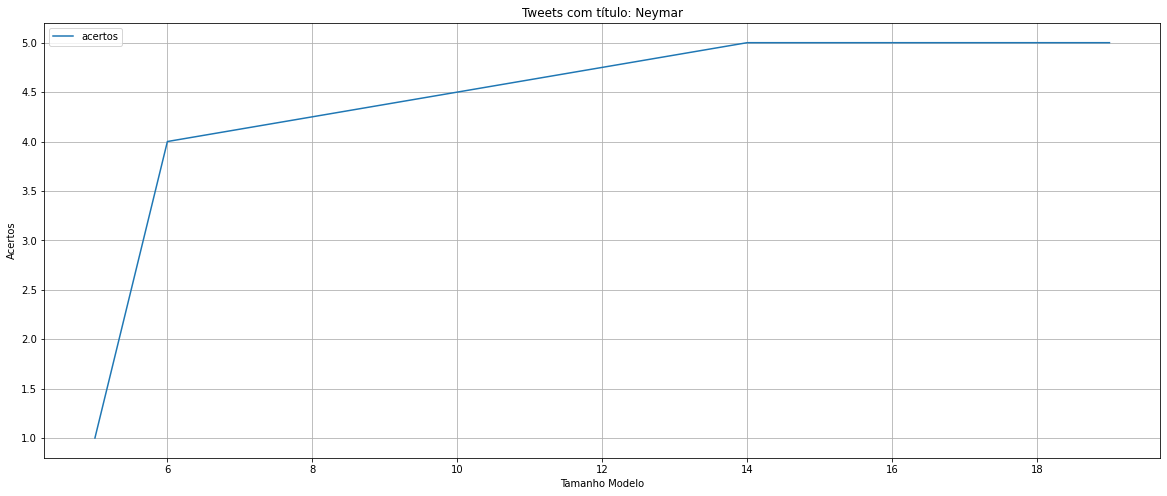

In [9]:
x = df_resultado['acertos'].values
y = df_resultado['tamanhoModelo'].values
tituloGrafico = 'Tweets com título: ' + title
pltRes = df_resultado.plot.line(x='tamanhoModelo', y = 'acertos', title=tituloGrafico,  xlabel='Tamanho Modelo', ylabel='Acertos',  figsize=(20,8)) 
pltRes.grid(True)



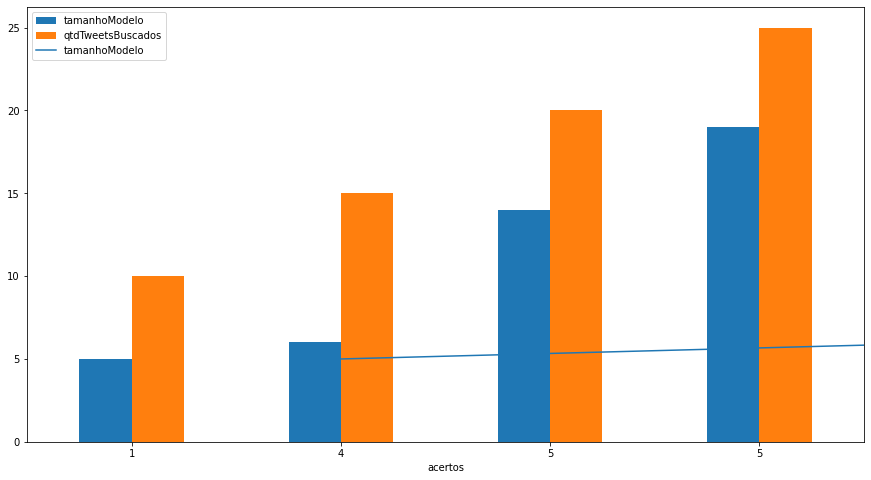

In [60]:
# Grafico de barras
fig, ax = plt.subplots(figsize = (15,8))
df_resultado.plot(x= 'acertos' , y= ['tamanhoModelo','qtdTweetsBuscados'], kind = 'bar', ax = ax).grid(False)
df_resultado.plot(x= 'acertos' , y= 'tamanhoModelo', kind = 'line', ax = ax, ms=50).grid(False)





In [ ]:
# salvar o modelo em arquivo
salvarModeloEmArquivo(modelo)